# comparison between OTB rectification and Shareloc

ellipsoid

## imports

In [32]:
import os
import numpy as np
import rasterio

from shareloc.image import Image
from shareloc.geomodels.rpc import RPC
from shareloc.geofunctions.rectification import compute_stereorectification_epipolar_grids
from shareloc.geofunctions.rectification_grid import RectificationGrid

from matplotlib import pyplot as plt

## load data

image and geom model

In [15]:
left_im_filename = '/work/OT/siaa/3D/Temporary/guinetj/data_PHR/IMGPHR_201871911276970797/IMG_PHR1B_P_201709281038045_SEN_PRG_FC_178608-001_R1C1_OTB.TIF'
right_im_filename = '/work/OT/siaa/3D/Temporary/guinetj/data_PHR/IMGPHR_201871911391952420/IMG_PHR1B_P_201709281038393_SEN_PRG_FC_178609-001_R1C1_OTB.TIF'
left_im = Image(left_im_filename)
right_im = Image(right_im_filename)

geom_model_left = RPC.from_any('/work/OT/siaa/3D/Temporary/guinetj/data_PHR/IMGPHR_201871911276970797/IMG_PHR1B_P_201709281038045_SEN_PRG_FC_178608-001_R1C1_OTB.geom', topleftconvention=True)
geom_model_right = RPC.from_any('/work/OT/siaa/3D/Temporary/guinetj/data_PHR/IMGPHR_201871911391952420/IMG_PHR1B_P_201709281038393_SEN_PRG_FC_178609-001_R1C1_OTB.geom', topleftconvention=True)

## rectification Shareloc

In [17]:
epi_step = 30
elevation_offset = 50.0
default_alt = 0.0
dem = None

In [10]:
left_grid, right_grid, img_size_row, img_size_col, mean_br = compute_stereorectification_epipolar_grids(left_im, geom_model_left, right_im, geom_model_right,dem, default_alt, epi_step, elevation_offset)
print("epipolar size {}x{}".format(img_size_row, img_size_col))
print("mean_baseline_ratio ", mean_br)

# rectification OTB

In [21]:
os.environ.pop("OTB_GEOID_FILE")
import otbApplication

stereo_app = otbApplication.Registry.CreateApplication("StereoRectificationGridGenerator")

stereo_app.SetParameterString("io.inleft", left_im_filename)
stereo_app.SetParameterString("io.inright", right_im_filename)
stereo_app.SetParameterInt("epi.step", epi_step)
if dem is not None:
    stereo_app.SetParameterString("epi.elevation.dem", dem)
if default_alt is not None:
    stereo_app.SetParameterFloat("epi.elevation.default", default_alt)


stereo_app.Execute()
# Export grids to numpy
left_grid_as_array = np.copy(stereo_app.GetVectorImageAsNumpyArray("io.outleft"))
right_grid_as_array = np.copy(stereo_app.GetVectorImageAsNumpyArray("io.outright"))
img_size_col_otb, img_size_row_otb, mean_br_otb = \
        stereo_app.GetParameterInt("epi.rectsizex"), \
        stereo_app.GetParameterInt("epi.rectsizey"), \
        stereo_app.GetParameterFloat("epi.baseline")

origin = stereo_app.GetImageOrigin("io.outleft")
spacing = stereo_app.GetImageSpacing("io.outleft")

print("epipolar size {}x{}".format(img_size_row_otb, img_size_col_otb))
print("mean_baseline_ratio ", mean_br_otb)

2021-02-17 07:39:15 (INFO): Loading kwl metadata from attached geom file /work/OT/siaa/3D/Temporary/guinetj/data_PHR/IMGPHR_201871911276970797/IMG_PHR1B_P_201709281038045_SEN_PRG_FC_178608-001_R1C1_OTB.geom
2021-02-17 07:39:15 (INFO): Loading kwl metadata from attached geom file /work/OT/siaa/3D/Temporary/guinetj/data_PHR/IMGPHR_201871911391952420/IMG_PHR1B_P_201709281038393_SEN_PRG_FC_178609-001_R1C1_OTB.geom
2021-02-17 07:39:15 (INFO) StereoRectificationGridGenerator: Elevation management: setting default height above ellipsoid to 0 meters
Computing epipolar grids ...: 100% [**************************************************] (7s)
epipolar size 44525x32377
mean_baseline_ratio  0.7431918382644653


## Compare grids

In [94]:
def compute_stats(data):
    return np.mean(data[:]), np.median(data[:]), np.std(data[:]), np.max(np.abs(data[:]))

In [96]:
diff_left_row = left_grid.data[0,:,:] - left_grid_as_array[:,:,1]
diff_left_col = left_grid.data[1,:,:] - left_grid_as_array[:,:,0]
diff_right_row = right_grid.data[0,:,:] - right_grid_as_array[:,:,1]
diff_right_col = right_grid.data[1,:,:] - right_grid_as_array[:,:,0]
print("diff left row mean/meadian/std/max|| :{}".format(compute_stats(diff_left_row)))
print("diff left col mean/meadian/std/max|| :{}".format(compute_stats(diff_left_col)))
print("diff right row mean/meadian/std/max|| :{}".format(compute_stats(diff_right_row)))
print("diff right col mean/meadian/std/max||:{}".format(compute_stats(diff_right_col)))


diff left row mean/meadian/std/max|| :(-0.0009494324910373579, -0.000998844731839199, 0.004911049185803295, 0.10651364328987256)
diff left col mean/meadian/std/max|| :(-0.0008362648885162524, -0.000883149545188644, 0.018468506397331726, 0.40612077582409256)
diff right row mean/meadian/std/max|| :(-0.0007595993469941157, -0.0009867927974482882, 0.006995513338346324, 0.1697093940583727)
diff right col mean/meadian/std/max||:(-0.000678572568504147, -0.0008504193565386231, 0.01862450250633751, 0.4432805037613434)


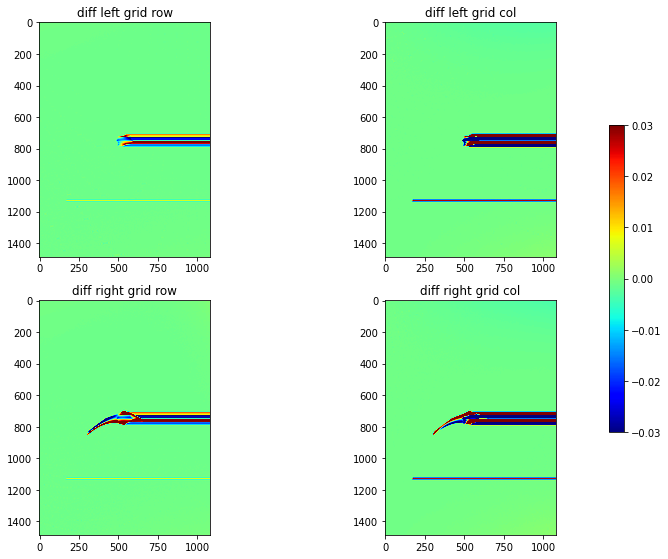

In [84]:
fig_size = 15
vmin = -0.03
vmax = 0.03
(fig, axes) = plt.subplots(nrows=2, ncols=2, figsize=(fig_size, 1.05 * fig_size / 2), subplot_kw={'aspect': 1})
im = axes[0,0].imshow(diff_left_row, cmap="jet", interpolation='spline36', vmin=vmin, vmax=vmax)
axes[0,0].set_title("diff left grid row")
axes[0,1].imshow(diff_left_col, cmap="jet", interpolation='spline36', vmin=vmin, vmax=vmax)
axes[0,1].set_title("diff left grid col")
axes[1,0].imshow(diff_right_row, cmap="jet", interpolation='spline36', vmin=vmin, vmax=vmax)
axes[1,0].set_title("diff right grid row")
axes[1,1].imshow(diff_right_col, cmap="jet", interpolation='spline36', vmin=vmin, vmax=vmax)
axes[1,1].set_title("diff right grid col")
fig.tight_layout()
fig.colorbar(im,ax=axes, shrink=0.6)
fig.savefig(os.path.join('/home/eh/guinetj/','diff_rectif_OTB_Shareloc_ellips_PACA.png'))

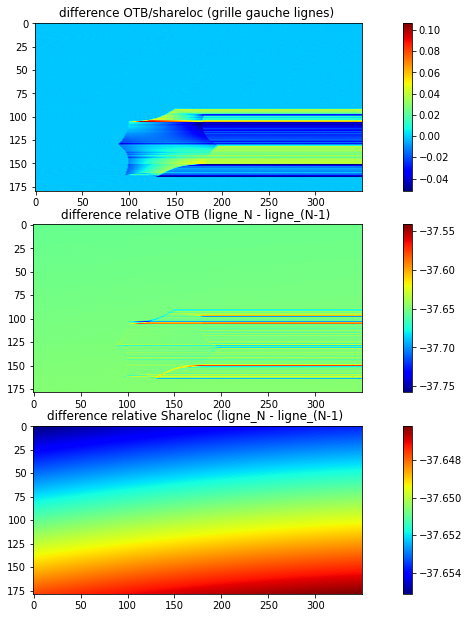

In [85]:
roi = [620,800,400,750]
(fig, axes) = plt.subplots(nrows=3, ncols=1, figsize=(fig_size, 1.4 * fig_size / 2), subplot_kw={'aspect': 1})
left_otb_roi = left_grid_as_array[roi[0]:roi[1],roi[2]:roi[3],1]
left_shareloc_roi =left_grid.data[0,roi[0]:roi[1],roi[2]:roi[3]]
diff = axes[0].imshow(diff_left_row[roi[0]:roi[1],roi[2]:roi[3]], cmap="jet", interpolation='spline36')
axes[0].set_title("difference OTB/shareloc (grille gauche lignes) ")
rel_otb = axes[1].imshow(left_otb_roi[1:,:] - left_otb_roi[:-1,:], cmap="jet", interpolation='spline36')
axes[1].set_title("difference relative OTB (ligne_N - ligne_(N-1) ")
rel_shareloc = axes[2].imshow(left_shareloc_roi[1:,:] - left_shareloc_roi[:-1,:], cmap="jet", interpolation='spline36')
axes[2].set_title("difference relative Shareloc (ligne_N - ligne_(N-1) ")
fig.colorbar(diff,ax=axes[0])
fig.colorbar(rel_otb,ax=axes[1])
fig.colorbar(rel_shareloc,ax=axes[2])
fig.savefig(os.path.join('/home/eh/guinetj/','diff_rectif_OTB_Shareloc_ellips_PACA_ROI.png'))